<a href="https://colab.research.google.com/github/MoniFarsang/NeuroAI/blob/main/Forward_activation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m pip install --upgrade pip

In [2]:
!python --version

Python 3.10.0


In [3]:
!pip install seaborn ncps

In [4]:
!pip install "numpy<2.0" 

In [5]:
!pip install tensorflow==2.10.0

In [19]:
!pip install networkx

  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
Using cached networkx-3.3-py3-none-any.whl (1.7 MB)


In [6]:
# Import libraries
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from ncps import wirings
from ncps.tf import LTC
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange

# Define wiring and cell types

In [7]:
class Wiring_with_names(wirings.Wiring):
    def __init__(self, units):
        super(Wiring_with_names, self).__init__(units)

    def get_graph(self, include_sensory_neurons=True, sensory_neurons=None, motor_neurons=None):
      """
      Returns a networkx.DiGraph object of the wiring diagram
      :param include_sensory_neurons: Whether to include the sensory neurons as nodes in the graph
      """
      if not self.is_built():
          raise ValueError(
              "Wiring is not built yet.\n"
              "This is probably because the input shape is not known yet.\n"
              "Consider calling the model.build(...) method using the shape of the inputs."
          )
      # Only import networkx package if we really need it
      import networkx as nx

      DG = nx.DiGraph()
      for i in range(self.units):
          neuron_type = self.get_type_of_neuron(i)
          if motor_neurons is None:
            DG.add_node("neuron_{:d}".format(i), neuron_type=neuron_type)
          else:
            DG.add_node(motor_neurons[i], neuron_type="motor")

      for i in range(self.input_dim):
        if sensory_neurons is None:
          DG.add_node("sensory_{:d}".format(i), neuron_type="sensory")
        else:
          DG.add_node(sensory_neurons[i], neuron_type="sensory")

      erev = self.adjacency_matrix
      sensory_erev = self.sensory_adjacency_matrix

      for src in range(self.input_dim):
          for dest in range(self.units):
              if self.sensory_adjacency_matrix[src, dest] != 0:
                  polarity = (
                      "excitatory" if sensory_erev[src, dest] >= 0.0 else "inhibitory"
                  )
                  sensory_name = "sensory_{:d}".format(src) if sensory_neurons is None else sensory_neurons[src]
                  motor_name = "neuron_{:d}".format(dest) if motor_neurons is None else motor_neurons[dest]
                  DG.add_edge(
                      "sensory_{:d}".format(src) if sensory_neurons is None else sensory_neurons[src],
                      "neuron_{:d}".format(dest) if motor_neurons is None else motor_neurons[dest],
                      polarity=polarity,
                  )

      for src in range(self.units):
          for dest in range(self.units):
              if self.adjacency_matrix[src, dest] != 0:
                  polarity = "excitatory" if erev[src, dest] >= 0.0 else "inhibitory"
                  motor_name_src = "neuron_{:d}".format(src) if motor_neurons is None else motor_neurons[src]
                  motor_name_dest = "neuron_{:d}".format(dest) if motor_neurons is None else motor_neurons[dest]
                  DG.add_edge(
                      "neuron_{:d}".format(src) if motor_neurons is None else motor_neurons[src],
                      "neuron_{:d}".format(dest) if motor_neurons is None else motor_neurons[dest],
                      polarity=polarity,
                  )
      return DG

    def draw_graph(
        self,
        layout="shell",
        neuron_colors=None,
        synapse_colors=None,
        draw_labels=False,
        sensory_neurons=None,
        motor_neurons=None
    ):
        """Draws a matplotlib graph of the wiring structure
        Examples::
            >>> import matplotlib.pyplot as plt
            >>> plt.figure(figsize=(6, 4))
            >>> legend_handles = wiring.draw_graph(draw_labels=True)
            >>> plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
            >>> plt.tight_layout()
            >>> plt.show()
        :param layout:
        :param neuron_colors:
        :param synapse_colors:
        :param draw_labels:
        :return:
        """

        # May switch to Cytoscape once support in Google Colab is available
        # https://stackoverflow.com/questions/62421021/how-do-i-install-cytoscape-on-google-colab
        import networkx as nx
        import matplotlib.patches as mpatches
        import matplotlib.pyplot as plt

        if isinstance(synapse_colors, str):
            synapse_colors = {
                "excitatory": synapse_colors,
                "inhibitory": synapse_colors,
            }
        elif synapse_colors is None:
            synapse_colors = {"excitatory": "tab:green", "inhibitory": "tab:red"}

        default_colors = {
            "inter": "tab:blue",
            "motor": "tab:orange",
            "sensory": "tab:olive",
        }
        if neuron_colors is None:
            neuron_colors = {}
        # Merge default with user provided color dict
        for k, v in default_colors.items():
            if not k in neuron_colors.keys():
                neuron_colors[k] = v

        legend_patches = []
        for k, v in neuron_colors.items():
            label = "{}{} neurons".format(k[0].upper(), k[1:])
            color = v
            legend_patches.append(mpatches.Patch(color=color, label=label))

        G = self.get_graph(sensory_neurons = sensory_neurons, motor_neurons = motor_neurons)
        layouts = {
            "kamada": nx.kamada_kawai_layout,
            "circular": nx.circular_layout,
            "random": nx.random_layout,
            "shell": nx.shell_layout,
            "spring": nx.spring_layout,
            "spectral": nx.spectral_layout,
            "spiral": nx.spiral_layout,
        }
        if not layout in layouts.keys():
            raise ValueError(
                "Unknown layer '{}', use one of '{}'".format(
                    layout, str(layouts.keys())
                )
            )
        pos = layouts[layout](G)

        # Draw neurons
        for i in range(self.units):
            if motor_neurons is None:
                node_name = "neuron_{:d}".format(i)
            else:
                node_name = motor_neurons[i]
            neuron_type = G.nodes[node_name]["neuron_type"]
            neuron_color = "tab:blue"
            if neuron_type in neuron_colors.keys():
                neuron_color = neuron_colors[neuron_type]
            nx.draw_networkx_nodes(G, pos, [node_name], node_color=neuron_color)

        # Draw sensory neurons
        for i in range(self.input_dim):
            if sensory_neurons is None:
                node_name = "sensory_{:d}".format(i)
            else: 
                node_name = sensory_neurons[i]
            neuron_color = "blue"
            if "sensory" in neuron_colors.keys():
                neuron_color = neuron_colors["sensory"]
            nx.draw_networkx_nodes(G, pos, [node_name], node_color=neuron_color)

        # Optional: draw labels
        if draw_labels:
            nx.draw_networkx_labels(G, pos)

        # Draw edges
        for node1, node2, data in G.edges(data=True):
            polarity = data["polarity"]
            edge_color = synapse_colors[polarity]
            nx.draw_networkx_edges(G, pos, [(node1, node2)], edge_color=edge_color)

        return legend_patches

In [8]:
@tf.keras.utils.register_keras_serializable(package="Custom", name="WiredNeurons")
class WiredNeurons(tf.keras.layers.RNN):
    def __init__(
        self,
        cell_type,
        wiring,
        mixed_memory: bool = False,
        input_mapping="affine",
        output_mapping="affine",
        ode_unfolds=6,
        epsilon=1e-8,
        initialization_ranges=None,
        return_sequences: bool = False,
        return_state: bool = False,
        go_backwards: bool = False,
        stateful: bool = False,
        unroll: bool = False,
        time_major: bool = False,
        **kwargs,
    ):

        cell = cell_type(
            wiring=wiring,
            input_mapping=input_mapping,
            output_mapping=output_mapping,
            ode_unfolds=ode_unfolds,
            epsilon=epsilon,
            initialization_ranges=initialization_ranges,
            **kwargs,
        )

        super(WiredNeurons, self).__init__(
            cell,
            return_sequences,
            return_state,
            go_backwards,
            stateful,
            unroll,
            time_major,
            **kwargs,
        )

In [9]:
@tf.keras.utils.register_keras_serializable(package="Custom", name="CTRNN_SA_Cell")
class CTRNN_SA_Cell(tf.keras.layers.AbstractRNNCell):

    def __init__(
        self,
        wiring,
        input_mapping="affine",
        output_mapping="affine",
        ode_unfolds=6,
        ode_solver='hybrid',
        epsilon=1e-8,
        **kwargs
    ):
        self._wiring = wiring
        self._input_mapping = input_mapping
        self._output_mapping = output_mapping
        self._ode_unfolds = ode_unfolds
        self._epsilon = epsilon

        if ode_solver in ['explicit', 'hybrid']:
            self._solver = ode_solver
        else:
            raise ValueError('ODE solver should be in [\'explicit\', \'hybrid\']')

        super(CTRNN_SA_Cell, self).__init__(name="CTRNN_SA_Cell")

    @property
    def state_size(self):
        return self._wiring.units
    
    @property
    def sensory_size(self):
        return self._wiring.input_dim

    @property
    def motor_size(self):
        return self._wiring.output_dim

    @property
    def output_size(self):
        return self.motor_size

    def build(self, input_shape):

        # Check if input_shape is nested tuple/list
        if isinstance(input_shape[0], tuple) or isinstance(
            input_shape[0], tf.TensorShape
        ):
            # Nested tuple -> First item represent feature dimension
            input_dim = input_shape[0][-1]
        else:
            input_dim = input_shape[-1]

        self._wiring.build(input_dim)

        self._params = {}
        self._params["gleak"] = self.add_weight(
            name="gleak",
            shape=(self.state_size,),
            dtype=tf.float32,
            initializer=tf.keras.initializers.Constant(1), #Cm=1, it is tau in notes Eq. (35), ltau, leaking conductance
            constraint=tf.keras.constraints.NonNeg()
        )

        self._params["sigma"] = self.add_weight(
            name="sigma",
            shape=(self.state_size, self.state_size),
            dtype=tf.float32,
            initializer=tf.keras.initializers.Constant(1),
        ) # sigma_H, recurrent variance

        self._params["mu"] = self.add_weight(
            name="mu",
            shape=(self.state_size, self.state_size),
            dtype=tf.float32,
            initializer=tf.keras.initializers.Constant(0),
        ) # mu_H, recurrent mean

        self._params["w"] = self.add_weight(
            name="w",
            shape=(self.state_size, self.state_size),
            dtype=tf.float32,
            constraint=tf.keras.constraints.MinMaxNorm(-2,2),
            initializer=tf.keras.initializers.Orthogonal(),
        ) # H, recurrent kernel

        self._params["sensory_sigma"] = self.add_weight(
            name="sensory_sigma",
            shape=(self.sensory_size, self.state_size),
            dtype=tf.float32,
            initializer=tf.keras.initializers.Constant(1),
        ) #sigma_I, input variance

        self._params["sensory_mu"] = self.add_weight(
            name="sensory_mu",
            shape=(self.sensory_size, self.state_size),
            dtype=tf.float32,
            initializer=tf.keras.initializers.Constant(0),
        ) # mu_I, input mean

        self._params["sensory_w"] = self.add_weight(
            name="sensory_w",
            shape=(self.sensory_size, self.state_size),
            dtype=tf.float32,
            constraint=tf.keras.constraints.MinMaxNorm(-1,1),
            initializer=tf.keras.initializers.GlorotUniform(),
        ) # I, input kernel

        self._params["sparsity_mask"] = tf.constant(
            np.abs(self._wiring.adjacency_matrix), dtype=tf.float32
        )

        self._params["sensory_sparsity_mask"] = tf.constant(
            np.abs(self._wiring.sensory_adjacency_matrix), dtype=tf.float32
        )

        self._params["cm"] = tf.constant(1, dtype=tf.float32)

        if self._input_mapping in ["affine", "linear"]:
            self._params["input_w"] = self.add_weight(
                name="input_w",
                shape=(self.sensory_size,),
                dtype=tf.float32,
                initializer=tf.keras.initializers.Constant(1),
            )
        if self._input_mapping == "affine":
            self._params["input_b"] = self.add_weight(
                name="input_b",
                shape=(self.sensory_size,),
                dtype=tf.float32,
                initializer=tf.keras.initializers.Constant(0),
            )

        if self._output_mapping in ["affine", "linear"]:
            self._params["output_w"] = self.add_weight(
                name="output_w",
                shape=(self.motor_size,),
                dtype=tf.float32,
                initializer=tf.keras.initializers.Constant(1),
            )
        if self._output_mapping == "affine":
            self._params["output_b"] = self.add_weight(
                name="output_b",
                shape=(self.motor_size,),
                dtype=tf.float32,
                initializer=tf.keras.initializers.Constant(0),
            )

        self.built = True

    def _tanh(self, v_pre, mu, sigma):
        v_pre = tf.expand_dims(v_pre, axis=-1)  # For broadcasting
        mues = v_pre + mu
        x = sigma * mues
        return tf.nn.tanh(x)

    def _ode_solver_explicit(self, inputs, state, elapsed_time):
        v_pre = state

        # We can pre-compute the effects of the sensory neurons here
        sensory_w_activation = self._params["sensory_w"] * self._tanh(
            inputs, self._params["sensory_mu"], self._params["sensory_sigma"]
        )
        sensory_w_activation *= self._params["sensory_sparsity_mask"]

        # Reduce over dimension 1 (=source sensory neurons)
        w_numerator_sensory = tf.reduce_sum(sensory_w_activation, axis=1)

        delta_t = tf.cast(
            elapsed_time / self._ode_unfolds, dtype=tf.float32 #self._params["cm"] = 1
        )

        # Unfold the multiply ODE multiple times into one RNN step
        for t in range(self._ode_unfolds):
            w_activation = self._params["w"] * self._tanh(
                v_pre, self._params["mu"], self._params["sigma"]
            )

            w_activation *= self._params["sparsity_mask"]

            # Reduce over dimension 1 (=source neurons)
            w_activation_all = tf.reduce_sum(w_activation, axis=1) + w_numerator_sensory

            v_pre_prime = - self._params["gleak"] * v_pre + w_activation_all

            v_pre = v_pre + v_pre_prime * delta_t

        return v_pre


    def _ode_solver_hybrid(self, inputs, state, elapsed_time):
        v_pre = state

        # We can pre-compute the effects of the sensory neurons here
        sensory_w_activation = self._params["sensory_w"] * self._tanh(
            inputs, self._params["sensory_mu"], self._params["sensory_sigma"]
        )
        sensory_w_activation *= self._params["sensory_sparsity_mask"]

        # Reduce over dimension 1 (=source sensory neurons)
        w_numerator_sensory = tf.reduce_sum(sensory_w_activation, axis=1)

        # cm/t is loop invariant
        cm_t = self._params["cm"] / tf.cast(
            elapsed_time / self._ode_unfolds, dtype=tf.float32
        ) #Cm = 1

        # Unfold the multiply ODE multiple times into one RNN step
        for t in range(self._ode_unfolds):
            w_activation = self._params["w"] * self._tanh(
                v_pre, self._params["mu"], self._params["sigma"]
            )

            w_activation *= self._params["sparsity_mask"]

            # Reduce over dimension 1 (=source neurons)
            w_numerator = tf.reduce_sum(w_activation, axis=1) + w_numerator_sensory

            numerator = cm_t * v_pre + w_numerator

            denominator = cm_t + self._params["gleak"]

            # Avoid dividing by 0 -- not needed, denominator is always positive
            v_pre = numerator / denominator

        return v_pre

    def _map_inputs(self, inputs):
        if self._input_mapping in ["affine", "linear"]:
            inputs = inputs * self._params["input_w"]
        if self._input_mapping == "affine":
            inputs = inputs + self._params["input_b"]
        return inputs

    def _map_outputs(self, state):
        output = state
        if self.motor_size < self.state_size:
            output = output[:, 0 : self.motor_size]

        if self._output_mapping in ["affine", "linear"]:
            output = output * self._params["output_w"]
        if self._output_mapping == "affine":
            output = output + self._params["output_b"]
        return output

    def call(self, inputs, states):
        if isinstance(inputs, (tuple, list)):
            # Irregularly sampled mode
            inputs, elapsed_time = inputs
        else:
            # Regularly sampled mode (elapsed time = 1 second)
            elapsed_time = 1.0
        inputs = self._map_inputs(inputs)   

        if self._solver == 'explicit':
            next_state = self._ode_solver_explicit(inputs, states[0], elapsed_time)
        else:
            next_state = self._ode_solver_hybrid(inputs, states[0], elapsed_time)

        outputs = self._map_outputs(next_state)

        return outputs, [next_state]


    def get_config(self):
        seralized = self._wiring.get_config()
        seralized["input_mapping"] = self._input_mapping
        seralized["output_mapping"] = self._output_mapping
        seralized["ode_unfolds"] = self._ode_unfolds
        seralized["epsilon"] = self._epsilon
        seralized["ode_solver"] = self._solver
        return seralized

    @classmethod
    def from_config(cls, config):
        wiring = wirings.Wiring.from_config(config)
        return cls(wiring=wiring, **config)
    

    def summary(self):
        print("=== Network statistics of CTRNN-SA ===")
        print("# Neurons : "+str(self.state_size))

        num_of_synapses = int(np.sum(np.abs(self._params["sparsity_mask"])))
        num_of_sensory_synapses = int(np.sum(np.abs(self._params["sensory_sparsity_mask"])))

        print("# Synapses: "+str(num_of_synapses+num_of_sensory_synapses)+" ("+str(num_of_sensory_synapses)+"/"+str(num_of_synapses)+")")
        print("# Inputs  : "+str(self.sensory_size))
        print("# Outputs : "+str(self.output_size))

        total_parameters = 0

        #for gleak
        total_parameters += self.state_size

        # Each synapse has W, mu and sigma as parameters (i.e 3 in total)
        total_parameters += 3*(num_of_sensory_synapses+num_of_synapses)

        print("# Parameters: "+str(total_parameters))

In [10]:
@tf.keras.utils.register_keras_serializable(package="Custom", name="Gap_Junction_Cell")
class Gap_Junction_Cell(tf.keras.layers.AbstractRNNCell):

    def __init__(
        self,
        wiring,
        input_mapping="affine",
        output_mapping="affine",
        ode_unfolds=6,
        epsilon=1e-8,
        **kwargs
    ):
        self._wiring = wiring
        self._input_mapping = input_mapping
        self._output_mapping = output_mapping
        self._ode_unfolds = ode_unfolds
        self._epsilon = epsilon

        #self._seed = seed
        super(Gap_Junction_Cell, self).__init__(name="Gap_Junction_Cell")

    @property
    def state_size(self):
        return self._wiring.units
    
    @property
    def sensory_size(self):
        return self._wiring.input_dim

    @property
    def motor_size(self):
        return self._wiring.output_dim

    @property
    def output_size(self):
        return self.motor_size

    def build(self, input_shape):

        # Check if input_shape is nested tuple/list
        if isinstance(input_shape[0], tuple) or isinstance(
            input_shape[0], tf.TensorShape
        ):
            # Nested tuple -> First item represent feature dimension
            input_dim = input_shape[0][-1]
        else:
            input_dim = input_shape[-1]

        self._wiring.build(input_dim)

        self._params = {}
        self._params["gleak"] = self.add_weight(
            name="gleak",
            shape=(self.state_size,),
            dtype=tf.float32,
            initializer=tf.keras.initializers.Constant(1),
            constraint=tf.keras.constraints.NonNeg()
        )

        self._params["vleak"] = self.add_weight(
            name="vleak",
            shape=(self.state_size,),
            dtype=tf.float32,
            initializer=tf.keras.initializers.Constant(0)
        )

        self._params["w"] = self.add_weight(
            name="w",
            shape=(self.state_size, self.state_size),
            dtype=tf.float32,
            constraint=tf.keras.constraints.MinMaxNorm(-2,2),
            initializer=tf.keras.initializers.Orthogonal(),
        ) # H, recurrent kernel

        self._params["sensory_w"] = self.add_weight(
            name="sensory_w",
            shape=(self.sensory_size, self.state_size),
            dtype=tf.float32,
            constraint=tf.keras.constraints.MinMaxNorm(-1,1),
            initializer=tf.keras.initializers.GlorotUniform(),
        ) # I, input kernel

        self._params["sparsity_mask"] = tf.constant(
            np.abs(self._wiring.adjacency_matrix), dtype=tf.float32
        )

        self._params["sensory_sparsity_mask"] = tf.constant(
            np.abs(self._wiring.sensory_adjacency_matrix), dtype=tf.float32
        )

        self._params["cm"] = self.add_weight(
            name="cm",
            shape=(self.state_size,),
            dtype=tf.float32,
            constraint=tf.keras.constraints.NonNeg(),
            initializer=tf.keras.initializers.Constant(1),
        )

        if self._input_mapping in ["affine", "linear"]:
            self._params["input_w"] = self.add_weight(
                name="input_w",
                shape=(self.sensory_size,),
                dtype=tf.float32,
                initializer=tf.keras.initializers.Constant(1),
            )
        if self._input_mapping == "affine":
            self._params["input_b"] = self.add_weight(
                name="input_b",
                shape=(self.sensory_size,),
                dtype=tf.float32,
                initializer=tf.keras.initializers.Constant(0),
            )

        if self._output_mapping in ["affine", "linear"]:
            self._params["output_w"] = self.add_weight(
                name="output_w",
                shape=(self.motor_size,),
                dtype=tf.float32,
                initializer=tf.keras.initializers.Constant(1),
            )
        if self._output_mapping == "affine":
            self._params["output_b"] = self.add_weight(
                name="output_b",
                shape=(self.motor_size,),
                dtype=tf.float32,
                initializer=tf.keras.initializers.Constant(0),
            )

        self.built = True

    def _ode_solver_explicit(self, inputs, state, elapsed_time):
        v_pre = state

        v_pre_bc = tf.expand_dims(v_pre, axis=-1)  # For broadcasting

        sensory_w_activation = self._params["sensory_w"] * (inputs-tf.transpose(v_pre))

        sensory_w_activation *= self._params["sensory_sparsity_mask"]

        # Reduce over dimension 1 (=source sensory neurons)
        w_numerator_sensory = tf.reduce_sum(sensory_w_activation, axis=1)

        delta_t = tf.cast(
            elapsed_time / self._ode_unfolds, dtype=tf.float32
        )

        # Unfold the multiply ODE multiple times into one RNN step
        for t in range(self._ode_unfolds):
            w_activation = self._params["w"] * (v_pre-tf.transpose(v_pre))

            w_activation *= self._params["sparsity_mask"]

            # Reduce over dimension 1 (=source neurons)
            w_activation_all = tf.reduce_sum(w_activation, axis=1) + w_numerator_sensory

            v_pre_prime = - self._params["gleak"]/self._params["cm"] * (self._params["vleak"]-v_pre) + 1/self._params["cm"]*w_activation_all

            v_pre = v_pre + v_pre_prime * delta_t

        return v_pre

    def _map_inputs(self, inputs):
        if self._input_mapping in ["affine", "linear"]:
            inputs = inputs * self._params["input_w"]
        if self._input_mapping == "affine":
            inputs = inputs + self._params["input_b"]
        return inputs

    def _map_outputs(self, state):
        output = state
        if self.motor_size < self.state_size:
            output = output[:, 0 : self.motor_size]

        if self._output_mapping in ["affine", "linear"]:
            output = output * self._params["output_w"]
        if self._output_mapping == "affine":
            output = output + self._params["output_b"]
        return output

    def call(self, inputs, states):
        if isinstance(inputs, (tuple, list)):
            # Irregularly sampled mode
            inputs, elapsed_time = inputs
        else:
            # Regularly sampled mode (elapsed time = 1 second)
            elapsed_time = 1.0
        inputs = self._map_inputs(inputs)   

        next_state = self._ode_solver_explicit(inputs, states[0], elapsed_time)

        outputs = self._map_outputs(next_state)

        return outputs, [next_state]


    def get_config(self):
        seralized = self._wiring.get_config()
        seralized["input_mapping"] = self._input_mapping
        seralized["output_mapping"] = self._output_mapping
        seralized["ode_unfolds"] = self._ode_unfolds
        seralized["epsilon"] = self._epsilon
        seralized["ode_solver"] = self._solver
        return seralized

    @classmethod
    def from_config(cls, config):
        wiring = wirings.Wiring.from_config(config)
        return cls(wiring=wiring, **config)
    

    def summary(self):
        print("=== Network statistics of Gap Junctions ===")
        print("# Neurons : "+str(self.state_size))

        num_of_synapses = int(np.sum(np.abs(self._params["sparsity_mask"])))
        num_of_sensory_synapses = int(np.sum(np.abs(self._params["sensory_sparsity_mask"])))

        print("# Synapses: "+str(num_of_synapses+num_of_sensory_synapses)+" ("+str(num_of_sensory_synapses)+"/"+str(num_of_synapses)+")")
        print("# Inputs  : "+str(self.sensory_size))
        print("# Outputs : "+str(self.output_size))

        total_parameters = 0

        #for gleak
        total_parameters += self.state_size

        # Each synapse has W as parameters (i.e 1 in total)
        total_parameters += 1*(num_of_sensory_synapses+num_of_synapses)

        print("# Parameters: "+str(total_parameters))

## Define Forward circuit

In [11]:
class Forward(Wiring_with_names):
    def __init__(self, units=1, output_dim=1):
        super(Forward, self).__init__(units)
        self.set_output_dim(output_dim)
        self.sparsity_level = 0 # Need no sparsity, all the connections are defined in the build function

    def build(self, input_shape):
        super().build(input_shape)
        self.sensory_adjacency_matrix[0,0] = 1 #idx0: source neuron index from sensory neurons, idx1: destination neuron index from units (shape: [input_dim, units])
        self.adjacency_matrix[0,0] = 1 #idx0: source neuron index from units, idx1: destination neuron index from units (shape: [units, units])

## Define Forward circuit without self-loop

In [12]:
class Forward_without_loop(Wiring_with_names):
    def __init__(self, units=1, output_dim=1):
        super(Forward_without_loop, self).__init__(units)
        self.set_output_dim(output_dim)
        self.sparsity_level = 0 # Need no sparsity, all the connections are defined in the build function

    def build(self, input_shape):
        super().build(input_shape)
        self.sensory_adjacency_matrix[0,0] = 1 #idx0: source neuron index from sensory neurons, idx1: destination neuron index from units (shape: [input_dim, units])
        #self.adjacency_matrix[0,0] = 1 #idx0: source neuron index from units, idx1: destination neuron index from units (shape: [units, units])

## Data-generator for forward activation without deactivation

In [13]:
def generate_forward_activation_on(n=100):
  N = 48 # Length of the time-series
  x_train_forward_activation_on = []
  y_train_forward_activation_on = []

  for i in range(n): 

    # Initialize the time-series data
    data_x1, data_y1 = [0] * N,  [0] * N

    # Set the signal of the input data
    # Generate signals with different start time and activation length 
    i_start1 = 2 + randrange(20)
    input_active_length1 = 2 + randrange(4)
    data_x1[i_start1:(i_start1 + input_active_length1)] = [1] * input_active_length1 # Activate signal from i_start input_active_length long

    x_train_forward_activation_on.append(data_x1)

    # Target output is a delayed activation 
    output_delay1 = 1 # Delay between the input activation and the output activation
    data_y1[(i_start1+output_delay1):] = [1] * (N-(i_start1+output_delay1)) # Activate signal from i_start + output_delay

    y_train_forward_activation_on.append(data_y1)
  
  x_train_forward_activation_on = np.stack(x_train_forward_activation_on, axis=0)
  y_train_forward_activation_on = np.stack(y_train_forward_activation_on, axis=0)

  # Print shapes
  print("x_train_forward_activation_on.shape: ", str(x_train_forward_activation_on.shape))
  print("y_train_forward_activation_on.shape: ", str(y_train_forward_activation_on.shape))

  return x_train_forward_activation_on, y_train_forward_activation_on

In [14]:
x_train_forward_activation_on, y_train_forward_activation_on = generate_forward_activation_on(100)

x_train_forward_activation_on.shape:  (100, 48)
y_train_forward_activation_on.shape:  (100, 48)


In [15]:
x_valid_forward_activation_on, y_valid_forward_activation_on = generate_forward_activation_on(20)

x_train_forward_activation_on.shape:  (20, 48)
y_train_forward_activation_on.shape:  (20, 48)


In [16]:
x_test_forward_activation_on, y_test_forward_activation_on = generate_forward_activation_on(10)

x_train_forward_activation_on.shape:  (10, 48)
y_train_forward_activation_on.shape:  (10, 48)


#### Plot some example data

<Figure size 800x400 with 0 Axes>

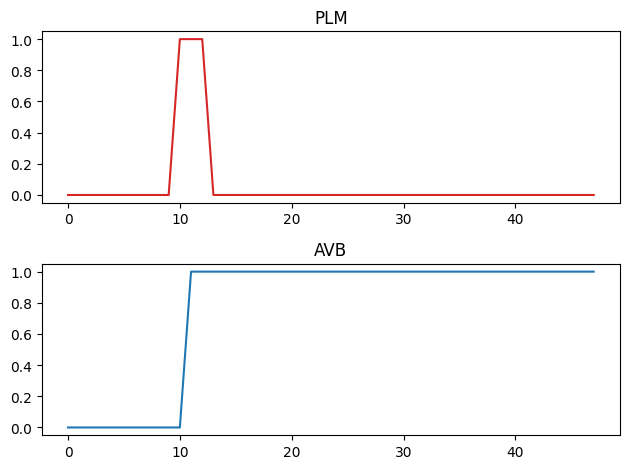

In [17]:
# Plotting the training data
plt.figure(figsize=(8, 4))
fig, axs = plt.subplots(2,1)
axs[0].plot(x_train_forward_activation_on[0, :], 'tab:red')
axs[0].set_title('PLM')
axs[1].plot(y_train_forward_activation_on[0, :], 'tab:blue')
axs[1].set_title('AVB')

plt.tight_layout()
plt.show()

# Forward circuit with self-loop
# Neuron type: LTC

## Create and compile keras model

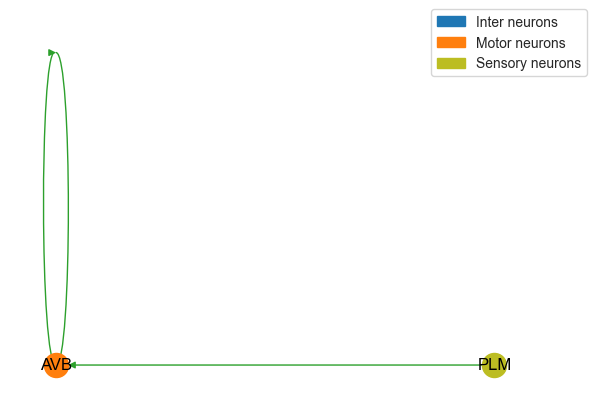

In [21]:
forward_architecture = Forward(1,1) 

ncp_model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 1)),
        LTC(forward_architecture, return_sequences=True, input_mapping=None, output_mapping=None),
    ]
)
ncp_model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = forward_architecture.draw_graph(draw_labels=True, 
                                                 sensory_neurons=["PLM"], 
                                                 motor_neurons=["AVB"])
plt.legend(handles=legend_handles, bbox_to_anchor=(1.1, 1.1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### Fit the first dataset (PLM activates AVB, AVB stays active because of its self-activation)

In [22]:
hist_forward_ncp = ncp_model.fit(x=x_train_forward_activation_on, y=y_train_forward_activation_on, batch_size=32, epochs=100, validation_data=(x_valid_forward_activation_on, y_valid_forward_activation_on))

Epoch 1/100
4/4 [==============================] - 19s 549ms/step - loss: 0.2617 - val_loss: 0.2139
Epoch 2/100
4/4 [==============================] - 1s 190ms/step - loss: 0.2109 - val_loss: 0.1850
Epoch 3/100
4/4 [==============================] - 1s 191ms/step - loss: 0.1955 - val_loss: 0.1740
Epoch 4/100
4/4 [==============================] - 1s 196ms/step - loss: 0.1920 - val_loss: 0.1696
Epoch 5/100
4/4 [==============================] - 1s 188ms/step - loss: 0.1911 - val_loss: 0.1673
Epoch 6/100
4/4 [==============================] - 1s 201ms/step - loss: 0.1905 - val_loss: 0.1654
Epoch 7/100
4/4 [==============================] - 1s 202ms/step - loss: 0.1888 - val_loss: 0.1635
Epoch 8/100
4/4 [==============================] - 1s 176ms/step - loss: 0.1862 - val_loss: 0.1613
Epoch 9/100
4/4 [==============================] - 1s 227ms/step - loss: 0.1832 - val_loss: 0.1590
Epoch 10/100
4/4 [==============================] - 1s 200ms/step - loss: 0.1800 - val_loss: 0.1567
Epoch 11

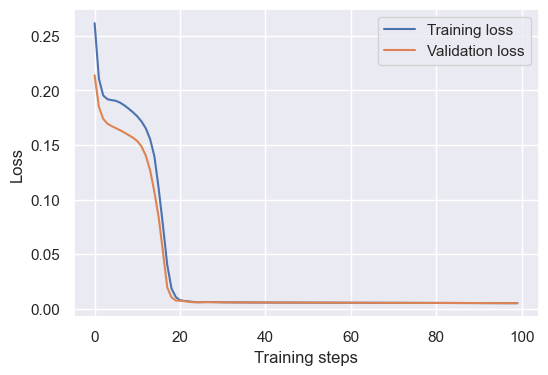

In [23]:
# Plotting the history data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist_forward_ncp.history["loss"], label="Training loss")
plt.plot(hist_forward_ncp.history["val_loss"], label="Validation loss")

plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

In [24]:
y_test_forward_activation_on_predicted = ncp_model.predict(x_test_forward_activation_on)

1/1 [==============================] - 1s 807ms/step


<Figure size 800x400 with 0 Axes>

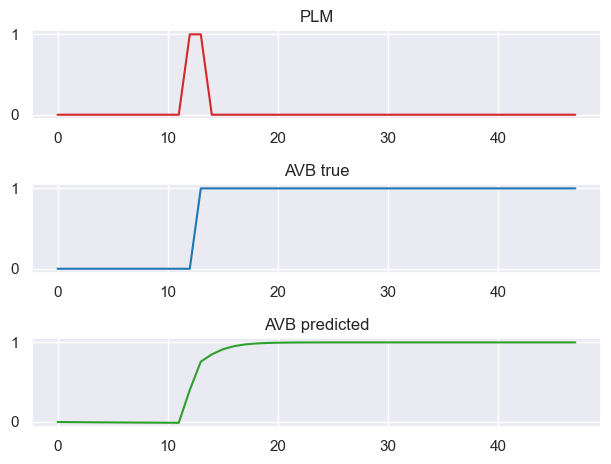

In [25]:
# Plotting the training data
plt.figure(figsize=(8, 4))
fig, axs = plt.subplots(3,1)
axs[0].plot(x_test_forward_activation_on[0, :], 'tab:red')
axs[0].set_title('PLM')
axs[1].plot(y_test_forward_activation_on[0, :], 'tab:blue')
axs[1].set_title('AVB true')
axs[2].plot(np.squeeze(y_test_forward_activation_on_predicted[0, :]), 'tab:green')
axs[2].set_title('AVB predicted')


plt.tight_layout()
plt.show()

## Print learned weights

In [26]:
ncp_model.variables

[<tf.Variable 'ltc_2/ltc_cell_2/gleak:0' shape=(1,) dtype=float32, numpy=array([0.23422877], dtype=float32)>,
 <tf.Variable 'ltc_2/ltc_cell_2/vleak:0' shape=(1,) dtype=float32, numpy=array([-0.16146919], dtype=float32)>,
 <tf.Variable 'ltc_2/ltc_cell_2/cm:0' shape=(1,) dtype=float32, numpy=array([1.2769696], dtype=float32)>,
 <tf.Variable 'ltc_2/ltc_cell_2/sigma:0' shape=(1, 1) dtype=float32, numpy=array([[5.6507907]], dtype=float32)>,
 <tf.Variable 'ltc_2/ltc_cell_2/mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.6226624]], dtype=float32)>,
 <tf.Variable 'ltc_2/ltc_cell_2/w:0' shape=(1, 1) dtype=float32, numpy=array([[0.9104225]], dtype=float32)>,
 <tf.Variable 'ltc_2/ltc_cell_2/erev:0' shape=(1, 1) dtype=float32, numpy=array([[1.3350744]], dtype=float32)>,
 <tf.Variable 'ltc_2/ltc_cell_2/sensory_sigma:0' shape=(1, 1) dtype=float32, numpy=array([[7.6017394]], dtype=float32)>,
 <tf.Variable 'ltc_2/ltc_cell_2/sensory_mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.86832607]], dtype=

# Forward circuit without self-loop
# Neuron type: LTC

## Create and compile keras model

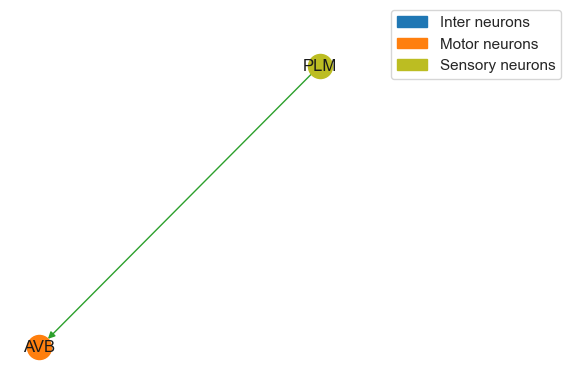

In [27]:
forward_without_loop_architecture = Forward_without_loop(1,1) 

ncp_model2 = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 1)),
        LTC(forward_without_loop_architecture, return_sequences=True, input_mapping=None, output_mapping=None),
    ]
)
ncp_model2.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = forward_without_loop_architecture.draw_graph(
    draw_labels=True,                                         
    sensory_neurons=["PLM"], 
    motor_neurons=["AVB"])

plt.legend(handles=legend_handles, bbox_to_anchor=(1.1, 1.1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### Fit the dataset (PLM activates AVB, AVB stays active because of its self-activation)

In [28]:
hist_forward_ncp2 = ncp_model2.fit(x=x_train_forward_activation_on, y=y_train_forward_activation_on, batch_size=32, epochs=200, validation_data=(x_valid_forward_activation_on, y_valid_forward_activation_on))

Epoch 1/200
4/4 [==============================] - 14s 723ms/step - loss: 0.6815 - val_loss: 0.6449
Epoch 2/200
4/4 [==============================] - 1s 157ms/step - loss: 0.5724 - val_loss: 0.5260
Epoch 3/200
4/4 [==============================] - 1s 153ms/step - loss: 0.4635 - val_loss: 0.4110
Epoch 4/200
4/4 [==============================] - 0s 126ms/step - loss: 0.3629 - val_loss: 0.3092
Epoch 5/200
4/4 [==============================] - 1s 136ms/step - loss: 0.2784 - val_loss: 0.2324
Epoch 6/200
4/4 [==============================] - 0s 124ms/step - loss: 0.2216 - val_loss: 0.1875
Epoch 7/200
4/4 [==============================] - 1s 130ms/step - loss: 0.1966 - val_loss: 0.1713
Epoch 8/200
4/4 [==============================] - 1s 133ms/step - loss: 0.1937 - val_loss: 0.1698
Epoch 9/200
4/4 [==============================] - 1s 146ms/step - loss: 0.1986 - val_loss: 0.1703
Epoch 10/200
4/4 [==============================] - 1s 244ms/step - loss: 0.2002 - val_loss: 0.1682
Epoch 11

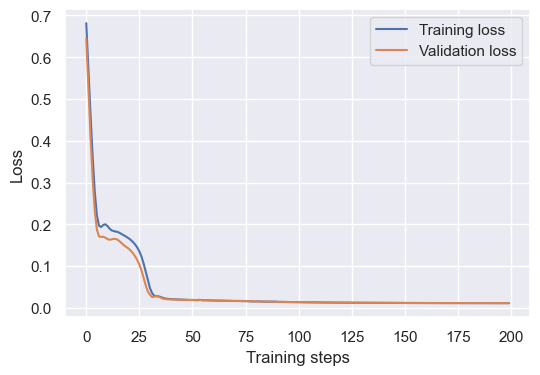

In [29]:
# Plotting the history data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist_forward_ncp2.history["loss"], label="Training loss")
plt.plot(hist_forward_ncp2.history["val_loss"], label="Validation loss")

plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

In [30]:
y_test_forward_activation_on_predicted2 = ncp_model2.predict(x_test_forward_activation_on)

1/1 [==============================] - 1s 857ms/step


<Figure size 800x400 with 0 Axes>

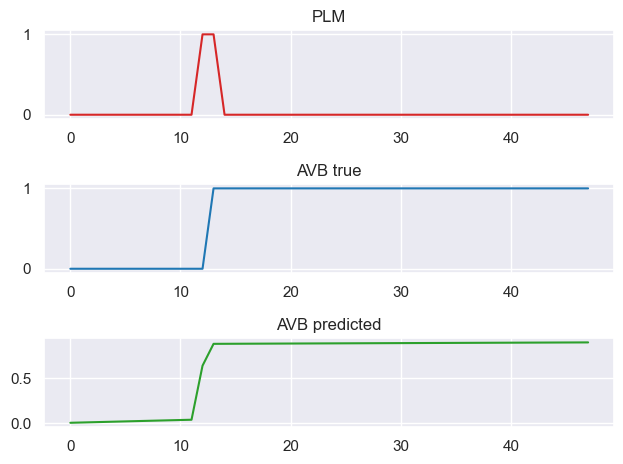

In [31]:
# Plotting the test data
plt.figure(figsize=(8, 4))
fig, axs = plt.subplots(3,1)
axs[0].plot(x_test_forward_activation_on[0, :], 'tab:red')
axs[0].set_title('PLM')
axs[1].plot(y_test_forward_activation_on[0, :], 'tab:blue')
axs[1].set_title('AVB true')
axs[2].plot(np.squeeze(y_test_forward_activation_on_predicted2[0, :]), 'tab:green')
axs[2].set_title('AVB predicted')


plt.tight_layout()
plt.show()

## Print learned weights

In [32]:
ncp_model2.variables

[<tf.Variable 'ltc_3/ltc_cell_3/gleak:0' shape=(1,) dtype=float32, numpy=array([-0.], dtype=float32)>,
 <tf.Variable 'ltc_3/ltc_cell_3/vleak:0' shape=(1,) dtype=float32, numpy=array([0.11508903], dtype=float32)>,
 <tf.Variable 'ltc_3/ltc_cell_3/cm:0' shape=(1,) dtype=float32, numpy=array([1.1137627], dtype=float32)>,
 <tf.Variable 'ltc_3/ltc_cell_3/sigma:0' shape=(1, 1) dtype=float32, numpy=array([[6.673761]], dtype=float32)>,
 <tf.Variable 'ltc_3/ltc_cell_3/mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.35900915]], dtype=float32)>,
 <tf.Variable 'ltc_3/ltc_cell_3/w:0' shape=(1, 1) dtype=float32, numpy=array([[0.46083632]], dtype=float32)>,
 <tf.Variable 'ltc_3/ltc_cell_3/erev:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Variable 'ltc_3/ltc_cell_3/sensory_sigma:0' shape=(1, 1) dtype=float32, numpy=array([[8.122894]], dtype=float32)>,
 <tf.Variable 'ltc_3/ltc_cell_3/sensory_mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.72436666]], dtype=float32)>,
 <tf

## Calculate the ODE based on the current weights

In [35]:
!pip install sympy

  Using cached sympy-1.13.2-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached sympy-1.13.2-py3-none-any.whl (6.2 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


In [33]:
dict_params = {}
params = ["gl", "xleak", "cm", "gamma", "mu", "w", "E", "sensory_gamma", "sensory_mu", "sensory_w", "sensory_E"]
for i, param in enumerate(params):
  if param in ["gl", "xleak", "cm"]:
    dict_params[param] = ncp_model2.variables[i][0].numpy()
  else:
    dict_params[param] = ncp_model2.variables[i][0][0].numpy()

In [36]:
import sympy

In [37]:
def sigmoid(x):
  return 1 / (1 + sympy.exp(-x))

In [38]:
x_i_dot = sympy.symbols('x_i_dot')
x_i = sympy.symbols('x_i')
x_j = sympy.symbols('x_j')

In [39]:
x_i_dot = - (dict_params["gl"]/dict_params["cm"] + dict_params["sensory_w"]/dict_params["cm"]*sigmoid(dict_params["sensory_gamma"]*x_j -dict_params["sensory_mu"]))*x_i + (dict_params["gl"]/dict_params["cm"]*dict_params["xleak"] + dict_params["sensory_w"]/dict_params["cm"]*sigmoid(dict_params["sensory_gamma"]*x_j -dict_params["sensory_mu"])*dict_params["sensory_E"])

### This is the differential equation after substituting all the learned weights

In [40]:
print('x_i_dot =', x_i_dot)

x_i_dot = -1.08239960670471*x_i/(1 + 2.06342*exp(-8.12289428710938*x_j)) + 1.14007346623035/(1 + 2.06342*exp(-8.12289428710938*x_j))


### Equation based on the signal of the pre-synaptic neuron

In [41]:
print('If x_j=0')
x_i_dot_when_x_j_is_0 = x_i_dot.subs(x_j, 0)
print('x_i_dot =', x_i_dot_when_x_j_is_0)

print('\nIf x_j=1')
x_i_dot_when_x_j_is_1 = x_i_dot.subs(x_j, 1)
print('x_i_dot =', x_i_dot_when_x_j_is_1)

If x_j=0
x_i_dot = 0.37215665381234 - 0.35333005078256*x_i

If x_j=1
x_i_dot = 1.13937599339269 - 1.08173741751469*x_i


### Calculate the derivative of the post-synaptic neuron in the 4 phases of the activation period

In [42]:
print('I. phase of the activation: x_j=0 and x_i=0')
x_i_dot_when_x_i_is_0_and_x_j_is_0 = x_i_dot.subs({x_i: 0, x_j: 0})
print('x_i_dot =', x_i_dot_when_x_i_is_0_and_x_j_is_0)

print('\n\nII. phase of the activation: x_j=1 and x_i=0')
x_i_dot_when_x_i_is_0_and_x_j_is_1 = x_i_dot.subs({x_i: 0, x_j: 1})
print('x_i_dot =', x_i_dot_when_x_i_is_0_and_x_j_is_1)

print('\n\nIII. phase of the activation: x_j=1 and x_i=1')
x_i_dot_when_x_i_is_1_and_x_j_is_1 = x_i_dot.subs({x_i: 1, x_j: 1})
print('x_i_dot =', x_i_dot_when_x_i_is_1_and_x_j_is_1)

print('\n\nIV. phase of the activation: x_j=0 and x_i=1')
x_i_dot_when_x_i_is_1_and_x_j_is_0 = x_i_dot.subs({x_i: 1, x_j: 0})
print('x_i_dot =', x_i_dot_when_x_i_is_1_and_x_j_is_0)

I. phase of the activation: x_j=0 and x_i=0
x_i_dot = 0.372156653812340


II. phase of the activation: x_j=1 and x_i=0
x_i_dot = 1.13937599339269


III. phase of the activation: x_j=1 and x_i=1
x_i_dot = 0.0576385758779998


IV. phase of the activation: x_j=0 and x_i=1
x_i_dot = 0.0188266030297796


### Some old calculations for specific parameters


[<tf.Variable 'ltc_1/ltc_cell_1/gleak:0' shape=(1,) dtype=float32, numpy=array([0.00286751], dtype=float32)>,

 <tf.Variable 'ltc_1/ltc_cell_1/vleak:0' shape=(1,) dtype=float32, numpy=array([0.23344076], dtype=float32)>,

 <tf.Variable 'ltc_1/ltc_cell_1/cm:0' shape=(1,) dtype=float32, numpy=array([1.1862696], dtype=float32)>,

 <tf.Variable 'ltc_1/ltc_cell_1/sigma:0' shape=(1, 1) dtype=float32, numpy=array([[7.665657]], dtype=float32)>,

 <tf.Variable 'ltc_1/ltc_cell_1/mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.5800008]], dtype=float32)>,

 <tf.Variable 'ltc_1/ltc_cell_1/w:0' shape=(1, 1) dtype=float32, numpy=array([[0.7507205]], dtype=float32)>,

 <tf.Variable 'ltc_1/ltc_cell_1/erev:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,

 <tf.Variable 'ltc_1/ltc_cell_1/sensory_sigma:0' shape=(1, 1) dtype=float32, numpy=array([[6.0172253]], dtype=float32)>,

 <tf.Variable 'ltc_1/ltc_cell_1/sensory_mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.67345476]], dtype=float32)>,

 <tf.Variable 'ltc_1/ltc_cell_1/sensory_w:0' shape=(1, 1) dtype=float32, numpy=array([[0.64989555]], dtype=float32)>,
 
 <tf.Variable 'ltc_1/ltc_cell_1/sensory_erev:0' shape=(1, 1) dtype=float32, numpy=array([[1.2224307]], dtype=float32)>]

##### Some calculations:

In [43]:
0.00286751/1.1862696

0.0024172498393282608

In [44]:
0.00286751/1.1862696*0.23344076

0.0005642846396026671

In [45]:
0.64989555/1.1862696

0.5478481029944626

In [46]:
import math

In [47]:
def sigmoid_math(x):
  return 1 / (1 + math.exp(-x))

In [48]:
0.00241+0.548*sigmoid_math(6.0172253*(-0.67345476))

0.01177251319449216

In [49]:
0.000564+0.548*sigmoid_math(6.0172253*(-0.67345476))*1.2224307

0.012009023558102287

In [50]:
0.00241+0.548*sigmoid_math(6.0172253*(1-0.67345476))

0.48303990258614016

In [51]:
0.000564+0.548*sigmoid_math(6.0172253*(1-0.67345476))*1.2224307

0.5881007482593071

##### LTC equation

State dynamics of $x_i$ \\

$\dot{x_i}(t) = \frac{g_{l_i}}{C_{m_i}} \left(x_{leak_i}-x_i(t)\right) + \sum_{j∈I_{in}}\frac{w_{ij}}{C_{m_i}}σ\left(γ_{ij}(x_j(t)-μ_{ij})\right)(E_{ij}-x_i)$

Separate state-dependent part

$\dot{x_i}(t) = -\left(\frac{g_{l_i}}{C_{m_i}} + \sum_{j∈I_{in}}\frac{w_{ij}}{C_{m_i}} σ\left(γ_{ij}(x_j(t)-μ_{ij})\right)\right) x_i(t) + \left(\frac{g_{l_i}}{C_{m_i}} x_{leak_i} +  \sum_{j∈I_{in}}\frac{w_{ij}}{C_{m_i}} σ\left(γ_{ij}(x_j(t)-μ_{ij})\right) E_{ij}\right)$

After substituting the values:

$\dot{x_i}(t) = -\left(\frac{0.00286751}{1.1862696} + \frac{0.64989555}{1.1862696} σ\left(6.0172253(x_j(t)-0.67345476)\right)\right) x_i(t) + \left(\frac{0.00286751}{1.1862696} *0.23344076 +  \frac{0.64989555}{1.1862696} σ\left(6.0172253(x_j(t)-0.67345476) \right) *1.2224307\right)$

$\dot{x_i}(t) = -\left(0.00241 + 0.548 * σ\left(6.0172253(x_j(t)-0.67345476)\right)\right) x_i(t) + \left(0.000564 +  0.548 * σ\left(6.0172253(x_j(t)-0.67345476) \right) *1.2224307\right)$

##### Checking the behavior

Let's make $x_j = 0$

$\dot{x_i}(t) = -0.0117* x_i(t) + 0.0120$

Let's make $x_j = 1$

$\dot{x_i}(t) = -0.483* x_i(t) + 0.588$

If $x_i(t)=0$ and $x_j(t)=0$: the derivative is 0.0122 -> very slow increase

If $x_i(t)=0$ and $x_j(t)=1$: the derivative is 0.588 -> starts to increase rapidly

If $x_i(t)=1$ and $x_j(t)=1$: the derivative is around 0.1 -> slow increase

If $x_i(t)=1$ and $x_j(t)=0$: the derivative is 0.0003 -> stabilizes


How can $x_i$ stay active even after the deactivation of $x_j$? 

$\dot{x_i}(t) = 0$

$x_i(t)=1$ and $x_j(t)=0$

$\dot{x_i}(t) =-\left(\frac{g_{l_i}}{C_{m_i}} + \sum_{j∈I_{in}}\frac{w_{ij}}{C_{m_i}} σ\left(γ_{ij}(x_j(t)-μ_{ij})\right)\right) x_i(t) + \left(\frac{g_{l_i}}{C_{m_i}} x_{leak_i} +  \sum_{j∈I_{in}}\frac{w_{ij}}{C_{m_i}} σ\left(γ_{ij}(x_j(t)-μ_{ij})\right) E_{ij}\right)$

After some simplification:

$\frac{g_{l_i}}{C_{m_i}} + \frac{w_{ij}}{C_{m_i}} σ\left(γ_{ij}(-μ_{ij})\right) =\frac{g_{l_i}}{C_{m_i}} x_{leak_i} + \frac{w_{ij}}{C_{m_i}} σ\left(γ_{ij}(-μ_{ij})\right) E_{ij}$

$A+B = A*m + B*n$

($m=x_{leak}=0.23344076$, $n=E_{rev}=1.2224307$)

Note: I don't compute the exact value of the equation above but it shows that it holds for some {A,B} pairs.

# Forward architecture with self-loop
# Neuron type: CTRNN

## Create and compile keras model

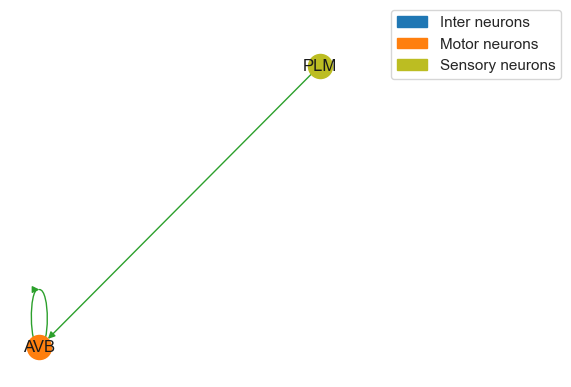

In [52]:
forward_architecture_with_loop = Forward(1,1) 

ncp_model_with_loop_ctrnn = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 1)),
        WiredNeurons(CTRNN_SA_Cell, forward_architecture_with_loop, return_sequences=True, input_mapping=None, output_mapping=None),
    ]
)
ncp_model_with_loop_ctrnn.compile(
    optimizer=keras.optimizers.Adam(0.001), loss='mean_squared_error'
)
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = forward_architecture_with_loop.draw_graph(
    draw_labels=True,                                         
    sensory_neurons=["PLM"], 
    motor_neurons=["AVB"],
    layout="spiral")

plt.legend(handles=legend_handles, bbox_to_anchor=(1.1, 1.1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### Fit the dataset (PLM activates AVB, AVB stays active because of its self-activation)

In [53]:
early_stopping_monitor = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=100,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [54]:
hist_forward_ncp_with_loop_ctrnn = ncp_model_with_loop_ctrnn.fit(x=x_train_forward_activation_on, y=y_train_forward_activation_on, batch_size=32, epochs=200, validation_data=(x_valid_forward_activation_on, y_valid_forward_activation_on), callbacks=[early_stopping_monitor])

Epoch 1/200
4/4 [==============================] - 29s 604ms/step - loss: 1.4641 - val_loss: 1.4240
Epoch 2/200
4/4 [==============================] - 1s 143ms/step - loss: 1.3259 - val_loss: 1.2779
Epoch 3/200
4/4 [==============================] - 1s 132ms/step - loss: 1.1945 - val_loss: 1.1493
Epoch 4/200
4/4 [==============================] - 0s 128ms/step - loss: 1.0818 - val_loss: 1.0453
Epoch 5/200
4/4 [==============================] - 1s 144ms/step - loss: 0.9888 - val_loss: 0.9631
Epoch 6/200
4/4 [==============================] - 1s 183ms/step - loss: 0.9153 - val_loss: 0.8979
Epoch 7/200
4/4 [==============================] - 1s 157ms/step - loss: 0.8565 - val_loss: 0.8452
Epoch 8/200
4/4 [==============================] - 1s 143ms/step - loss: 0.8087 - val_loss: 0.8016
Epoch 9/200
4/4 [==============================] - 1s 137ms/step - loss: 0.7688 - val_loss: 0.7648
Epoch 10/200
4/4 [==============================] - 1s 142ms/step - loss: 0.7350 - val_loss: 0.7329
Epoch 11

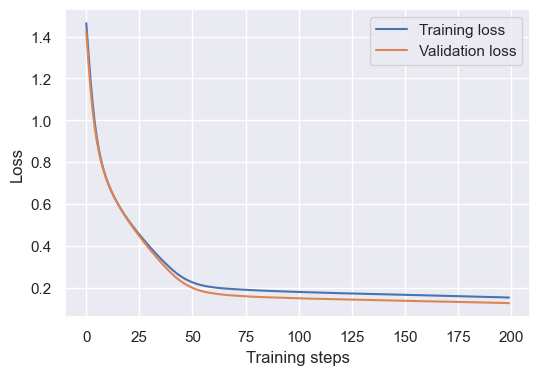

In [55]:
# Plotting the history data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist_forward_ncp_with_loop_ctrnn.history["loss"], label="Training loss")
plt.plot(hist_forward_ncp_with_loop_ctrnn.history["val_loss"], label="Validation loss")

plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

In [56]:
y_test_forward_activation_on_with_loop_ctrnn_predicted2 = ncp_model_with_loop_ctrnn.predict(x_test_forward_activation_on)

1/1 [==============================] - 1s 774ms/step


<Figure size 800x400 with 0 Axes>

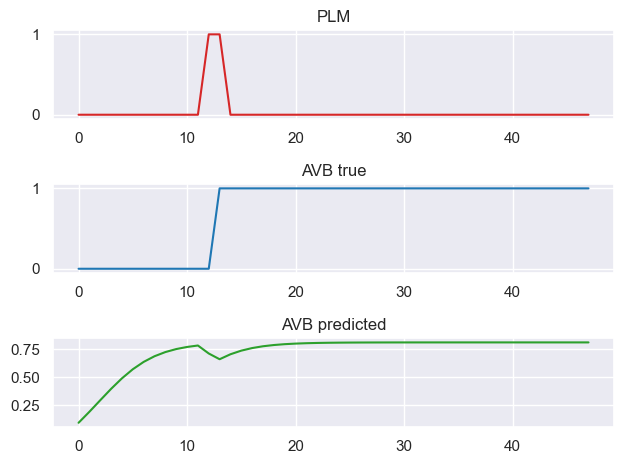

In [57]:
# Plotting the training data
plt.figure(figsize=(8, 4))
fig, axs = plt.subplots(3,1)
axs[0].plot(x_test_forward_activation_on[0, :], 'tab:red')
axs[0].set_title('PLM')
axs[1].plot(y_test_forward_activation_on[0, :], 'tab:blue')
axs[1].set_title('AVB true')
axs[2].plot(np.squeeze(y_test_forward_activation_on_with_loop_ctrnn_predicted2[0, :]), 'tab:green')
axs[2].set_title('AVB predicted')


plt.tight_layout()
plt.show()

## Print learned weights

In [58]:
ncp_model_with_loop_ctrnn.variables

[<tf.Variable 'wired_neurons/CTRNN_SA_Cell/gleak:0' shape=(1,) dtype=float32, numpy=array([0.9585148], dtype=float32)>,
 <tf.Variable 'wired_neurons/CTRNN_SA_Cell/sigma:0' shape=(1, 1) dtype=float32, numpy=array([[1.0300663]], dtype=float32)>,
 <tf.Variable 'wired_neurons/CTRNN_SA_Cell/mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.08426841]], dtype=float32)>,
 <tf.Variable 'wired_neurons/CTRNN_SA_Cell/w:0' shape=(1, 1) dtype=float32, numpy=array([[1.0572093]], dtype=float32)>,
 <tf.Variable 'wired_neurons/CTRNN_SA_Cell/sensory_sigma:0' shape=(1, 1) dtype=float32, numpy=array([[0.48196596]], dtype=float32)>,
 <tf.Variable 'wired_neurons/CTRNN_SA_Cell/sensory_mu:0' shape=(1, 1) dtype=float32, numpy=array([[-0.08748606]], dtype=float32)>,
 <tf.Variable 'wired_neurons/CTRNN_SA_Cell/sensory_w:0' shape=(1, 1) dtype=float32, numpy=array([[-0.23817067]], dtype=float32)>]

## Calculate the ODE based on the current weights

In [59]:
dict_params_CTRNN = {}
params_CTRNN = ["gl", "gamma", "mu", "w", "sensory_gamma", "sensory_mu", "sensory_w"]
for i, param in enumerate(params_CTRNN):
  if param=="gl":
    dict_params_CTRNN[param] = ncp_model_with_loop_ctrnn.variables[i][0].numpy()
  else:
    dict_params_CTRNN[param] = ncp_model_with_loop_ctrnn.variables[i][0][0].numpy()

In [60]:
import sympy

In [61]:
def tanh(x):
  return sympy.tanh(x)

In [62]:
x_i_dot_ctrnn = sympy.symbols('x_i_dot')
x_i_ctrnn = sympy.symbols('x_i')
x_j_ctrnn = sympy.symbols('x_j')

In [63]:
x_i_dot_ctrnn = -dict_params_CTRNN["gl"]*x_i_ctrnn + (dict_params_CTRNN["sensory_w"]*tanh(dict_params_CTRNN["sensory_gamma"]*(x_j_ctrnn + dict_params_CTRNN["sensory_mu"]))) + (dict_params_CTRNN["w"]*tanh(dict_params_CTRNN["gamma"]*(x_i_ctrnn + dict_params_CTRNN["mu"])))

### This is the differential equation after substituting all the learned weights

In [64]:
print('x_i_dot =', x_i_dot_ctrnn)

x_i_dot = -0.958514809608459*x_i + 1.05720925331116*tanh(1.03006625175476*x_i + 0.0868020488188836) - 0.23817066848278*tanh(0.481965959072113*x_j - 0.0421653020776613)


### Equation based on the signal of the pre-synaptic neuron

In [65]:
print('If x_j=0')
x_i_dot_ctrnn_when_x_j_is_0 = x_i_dot_ctrnn.subs(x_j_ctrnn, 0)
print('x_i_dot =', x_i_dot_ctrnn_when_x_j_is_0)

print('\nIf x_j=1')
x_i_dot_ctrnn_when_x_j_is_1 = x_i_dot_ctrnn.subs(x_j_ctrnn, 1)
print('x_i_dot =', x_i_dot_ctrnn_when_x_j_is_1)

If x_j=0
x_i_dot = -0.958514809608459*x_i + 1.05720925331116*tanh(1.03006625175476*x_i + 0.0868020488188836) + 0.0100365908267416

If x_j=1
x_i_dot = -0.958514809608459*x_i + 1.05720925331116*tanh(1.03006625175476*x_i + 0.0868020488188836) - 0.0984786159172032


### Calculate the derivative of the post-synaptic neuron in the 4 phases of the activation period

In [66]:
print('I. phase of the activation: x_j=0 and x_i=0')
x_i_dot_ctrnn_when_x_i_is_0_and_x_j_is_0 = x_i_dot_ctrnn.subs({x_i_ctrnn: 0, x_j_ctrnn: 0})
print('x_i_dot =', x_i_dot_ctrnn_when_x_i_is_0_and_x_j_is_0)

print('\n\nII. phase of the activation: x_j=1 and x_i=0')
x_i_dot_ctrnn_when_x_i_is_0_and_x_j_is_1 = x_i_dot_ctrnn.subs({x_i_ctrnn: 0, x_j_ctrnn: 1})
print('x_i_dot =', x_i_dot_ctrnn_when_x_i_is_0_and_x_j_is_1)

print('\n\nIII. phase of the activation: x_j=1 and x_i=1')
x_i_dot_ctrnn_when_x_i_is_1_and_x_j_is_1 = x_i_dot_ctrnn.subs({x_i_ctrnn: 1, x_j_ctrnn: 1})
print('x_i_dot =', x_i_dot_ctrnn_when_x_i_is_1_and_x_j_is_1)

print('\n\nIV. phase of the activation: x_j=0 and x_i=1')
x_i_dot_ctrnn_when_x_i_is_1_and_x_j_is_0 = x_i_dot_ctrnn.subs({x_i_ctrnn: 1, x_j_ctrnn: 0})
print('x_i_dot =', x_i_dot_ctrnn_when_x_i_is_1_and_x_j_is_0)

I. phase of the activation: x_j=0 and x_i=0
x_i_dot = 0.101574734475146


II. phase of the activation: x_j=1 and x_i=0
x_i_dot = -0.00694047226879839


III. phase of the activation: x_j=1 and x_i=1
x_i_dot = -0.204378635455028


IV. phase of the activation: x_j=0 and x_i=1
x_i_dot = -0.0958634287110836


# Forward architecture without self-loop
# Neuron type: CTRNN

## Create and compile keras model

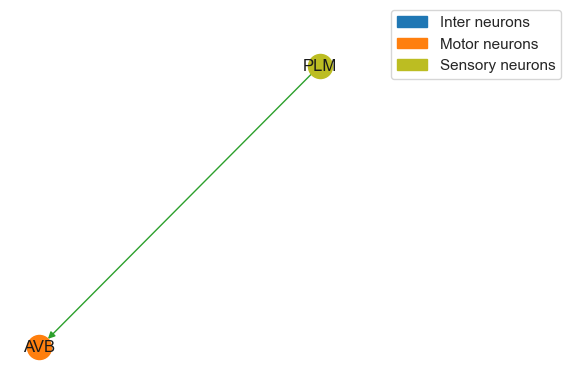

In [67]:
forward_architecture_without_loop = Forward_without_loop(1,1) 

ncp_model_without_loop_ctrnn = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 1)),
        WiredNeurons(CTRNN_SA_Cell, forward_architecture_without_loop, return_sequences=True, input_mapping=None, output_mapping=None),
    ]
)
ncp_model_without_loop_ctrnn.compile(
    optimizer=keras.optimizers.Adam(0.001), loss='mean_squared_error'
)
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = forward_architecture_without_loop.draw_graph(
    draw_labels=True,                                         
    sensory_neurons=["PLM"], 
    motor_neurons=["AVB"],
    layout="spiral")

plt.legend(handles=legend_handles, bbox_to_anchor=(1.1, 1.1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### Fit the dataset (PLM activates AVB, AVB stays active because of its self-activation)

In [68]:
early_stopping_monitor = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=100,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [69]:
hist_forward_ncp_without_loop_ctrnn = ncp_model_without_loop_ctrnn.fit(x=x_train_forward_activation_on, y=y_train_forward_activation_on, batch_size=32, epochs=500, validation_data=(x_valid_forward_activation_on, y_valid_forward_activation_on), callbacks=[early_stopping_monitor])

Epoch 1/500
4/4 [==============================] - 11s 409ms/step - loss: 0.6467 - val_loss: 0.6913
Epoch 2/500
4/4 [==============================] - 0s 100ms/step - loss: 0.6430 - val_loss: 0.6856
Epoch 3/500
4/4 [==============================] - 0s 101ms/step - loss: 0.6376 - val_loss: 0.6798
Epoch 4/500
4/4 [==============================] - 0s 119ms/step - loss: 0.6321 - val_loss: 0.6739
Epoch 5/500
4/4 [==============================] - 1s 166ms/step - loss: 0.6266 - val_loss: 0.6679
Epoch 6/500
4/4 [==============================] - 1s 135ms/step - loss: 0.6210 - val_loss: 0.6618
Epoch 7/500
4/4 [==============================] - 1s 149ms/step - loss: 0.6153 - val_loss: 0.6557
Epoch 8/500
4/4 [==============================] - 1s 142ms/step - loss: 0.6096 - val_loss: 0.6495
Epoch 9/500
4/4 [==============================] - 1s 167ms/step - loss: 0.6038 - val_loss: 0.6432
Epoch 10/500
4/4 [==============================] - 1s 144ms/step - loss: 0.5979 - val_loss: 0.6368
Epoch 11

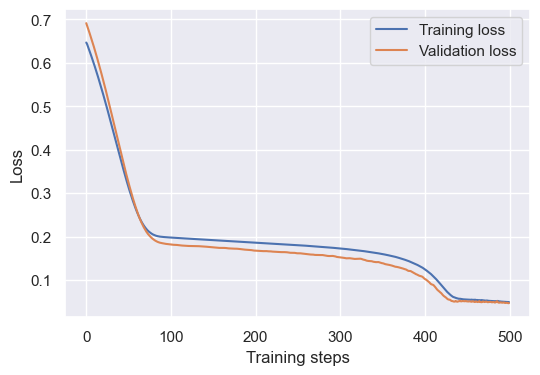

In [70]:
# Plotting the history data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist_forward_ncp_without_loop_ctrnn.history["loss"], label="Training loss")
plt.plot(hist_forward_ncp_without_loop_ctrnn.history["val_loss"], label="Validation loss")

plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

In [71]:
y_test_forward_activation_on_without_loop_ctrnn_predicted2 = ncp_model_without_loop_ctrnn.predict(x_test_forward_activation_on)

1/1 [==============================] - 1s 666ms/step


<Figure size 800x400 with 0 Axes>

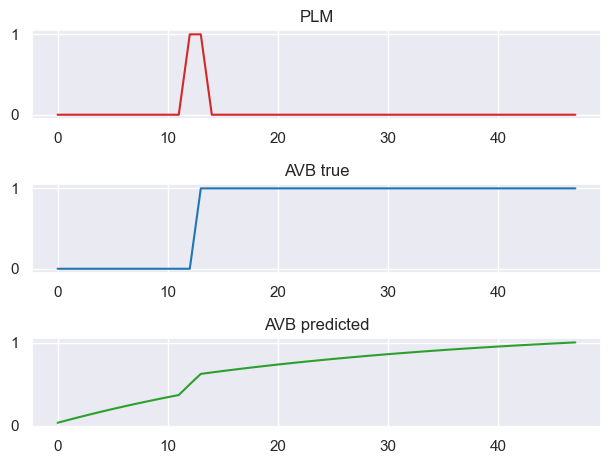

In [72]:
# Plotting the training data
plt.figure(figsize=(8, 4))
fig, axs = plt.subplots(3,1)
axs[0].plot(x_test_forward_activation_on[0, :], 'tab:red')
axs[0].set_title('PLM')
axs[1].plot(y_test_forward_activation_on[0, :], 'tab:blue')
axs[1].set_title('AVB true')
axs[2].plot(np.squeeze(y_test_forward_activation_on_without_loop_ctrnn_predicted2[0, :]), 'tab:green')
axs[2].set_title('AVB predicted')


plt.tight_layout()
plt.show()

## Print learned weights

In [73]:
ncp_model_without_loop_ctrnn.variables

[<tf.Variable 'wired_neurons_1/CTRNN_SA_Cell/gleak:0' shape=(1,) dtype=float32, numpy=array([0.0304274], dtype=float32)>,
 <tf.Variable 'wired_neurons_1/CTRNN_SA_Cell/sigma:0' shape=(1, 1) dtype=float32, numpy=array([[1.]], dtype=float32)>,
 <tf.Variable 'wired_neurons_1/CTRNN_SA_Cell/mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Variable 'wired_neurons_1/CTRNN_SA_Cell/w:0' shape=(1, 1) dtype=float32, numpy=array([[-0.9997616]], dtype=float32)>,
 <tf.Variable 'wired_neurons_1/CTRNN_SA_Cell/sensory_sigma:0' shape=(1, 1) dtype=float32, numpy=array([[1.240091]], dtype=float32)>,
 <tf.Variable 'wired_neurons_1/CTRNN_SA_Cell/sensory_mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.19162995]], dtype=float32)>,
 <tf.Variable 'wired_neurons_1/CTRNN_SA_Cell/sensory_w:0' shape=(1, 1) dtype=float32, numpy=array([[0.15810445]], dtype=float32)>]

## Calculate the ODE based on the current weights

In [74]:
dict_params_CTRNN = {}
params_CTRNN = ["gl", "gamma", "mu", "w", "sensory_gamma", "sensory_mu", "sensory_w"]
for i, param in enumerate(params_CTRNN):
  if param=="gl":
    dict_params_CTRNN[param] = ncp_model_without_loop_ctrnn.variables[i][0].numpy()
  else:
    dict_params_CTRNN[param] = ncp_model_without_loop_ctrnn.variables[i][0][0].numpy()

In [75]:
import sympy

In [76]:
def tanh(x):
  return sympy.tanh(x)

In [77]:
x_i_dot_ctrnn = sympy.symbols('x_i_dot')
x_i_ctrnn = sympy.symbols('x_i')
x_j_ctrnn = sympy.symbols('x_j')

In [78]:
x_i_dot_ctrnn = -dict_params_CTRNN["gl"]*x_i_ctrnn + (dict_params_CTRNN["sensory_w"]*tanh(dict_params_CTRNN["sensory_gamma"]*(x_j_ctrnn + dict_params_CTRNN["sensory_mu"])))

### This is the differential equation after substituting all the learned weights

In [79]:
print('x_i_dot =', x_i_dot_ctrnn)

x_i_dot = -0.0304273981601*x_i + 0.158104449510574*tanh(1.24009096622467*x_j + 0.237638565180227)


### Equation based on the signal of the pre-synaptic neuron

In [80]:
print('If x_j=0')
x_i_dot_ctrnn_when_x_j_is_0 = x_i_dot_ctrnn.subs(x_j_ctrnn, 0)
print('x_i_dot =', x_i_dot_ctrnn_when_x_j_is_0)

print('\nIf x_j=1')
x_i_dot_ctrnn_when_x_j_is_1 = x_i_dot_ctrnn.subs(x_j_ctrnn, 1)
print('x_i_dot =', x_i_dot_ctrnn_when_x_j_is_1)

If x_j=0
x_i_dot = 0.0368800824503249 - 0.0304273981601*x_i

If x_j=1
x_i_dot = 0.142458706931947 - 0.0304273981601*x_i


### Calculate the derivative of the post-synaptic neuron in the 4 phases of the activation period

In [81]:
print('I. phase of the activation: x_j=0 and x_i=0')
x_i_dot_ctrnn_when_x_i_is_0_and_x_j_is_0 = x_i_dot_ctrnn.subs({x_i_ctrnn: 0, x_j_ctrnn: 0})
print('x_i_dot =', x_i_dot_ctrnn_when_x_i_is_0_and_x_j_is_0)

print('\n\nII. phase of the activation: x_j=1 and x_i=0')
x_i_dot_ctrnn_when_x_i_is_0_and_x_j_is_1 = x_i_dot_ctrnn.subs({x_i_ctrnn: 0, x_j_ctrnn: 1})
print('x_i_dot =', x_i_dot_ctrnn_when_x_i_is_0_and_x_j_is_1)

print('\n\nIII. phase of the activation: x_j=1 and x_i=1')
x_i_dot_ctrnn_when_x_i_is_1_and_x_j_is_1 = x_i_dot_ctrnn.subs({x_i_ctrnn: 1, x_j_ctrnn: 1})
print('x_i_dot =', x_i_dot_ctrnn_when_x_i_is_1_and_x_j_is_1)

print('\n\nIV. phase of the activation: x_j=0 and x_i=1')
x_i_dot_ctrnn_when_x_i_is_1_and_x_j_is_0 = x_i_dot_ctrnn.subs({x_i_ctrnn: 1, x_j_ctrnn: 0})
print('x_i_dot =', x_i_dot_ctrnn_when_x_i_is_1_and_x_j_is_0)

I. phase of the activation: x_j=0 and x_i=0
x_i_dot = 0.0368800824503249


II. phase of the activation: x_j=1 and x_i=0
x_i_dot = 0.142458706931947


III. phase of the activation: x_j=1 and x_i=1
x_i_dot = 0.112031308771847


IV. phase of the activation: x_j=0 and x_i=1
x_i_dot = 0.00645268429022488


# Forward architecture without self-loop
# Neuron type: gap junction (unidirectional!)

## Create and compile keras model

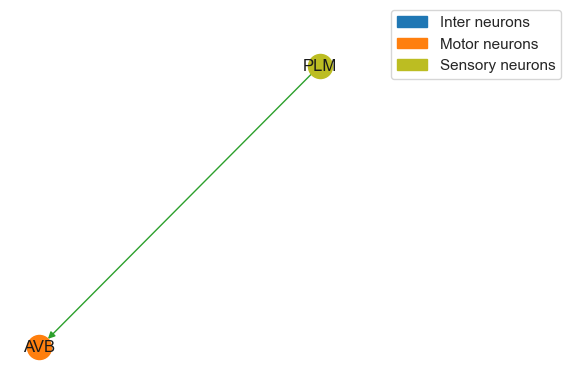

In [82]:
forward_architecture_without_loop = Forward_without_loop(1,1) 

ncp_model_without_loop_gj = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 1)),
        WiredNeurons(Gap_Junction_Cell, forward_architecture_without_loop, return_sequences=True, input_mapping=None, output_mapping=None),
    ]
)
ncp_model_without_loop_gj.compile(
    optimizer=keras.optimizers.Adam(0.001), loss='mean_squared_error'
)
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = forward_architecture_without_loop.draw_graph(
    draw_labels=True,                                         
    sensory_neurons=["PLM"], 
    motor_neurons=["AVB","AVA"],
    layout="spiral")

plt.legend(handles=legend_handles, bbox_to_anchor=(1.1, 1.1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### Fit the dataset (PLM activates AVB, AVB stays active because of its self-activation)

In [83]:
early_stopping_monitor = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=100,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

The training gives nans sometimes from the very beginning, probably we need better initial values. Now it is ok to build the model and run the fitting again

In [84]:
hist_forward_ncp_without_loop_gj = ncp_model_without_loop_gj.fit(x=x_train_forward_activation_on, y=y_train_forward_activation_on, batch_size=1, epochs=300, validation_data=(x_valid_forward_activation_on, y_valid_forward_activation_on), callbacks=[early_stopping_monitor])

Epoch 1/300
100/100 [==============================] - 11s 57ms/step - loss: 430172274688.0000 - val_loss: 86436331520.0000
Epoch 2/300
100/100 [==============================] - 5s 47ms/step - loss: 54140944384.0000 - val_loss: 37086584832.0000
Epoch 3/300
100/100 [==============================] - 5s 52ms/step - loss: 26274418688.0000 - val_loss: 22194442240.0000
Epoch 4/300
100/100 [==============================] - 5s 48ms/step - loss: 16578498560.0000 - val_loss: 14898681856.0000
Epoch 5/300
100/100 [==============================] - 5s 48ms/step - loss: 11549478912.0000 - val_loss: 10764665856.0000
Epoch 6/300
100/100 [==============================] - 5s 52ms/step - loss: 8600918016.0000 - val_loss: 8207481856.0000
Epoch 7/300
100/100 [==============================] - 5s 47ms/step - loss: 6702473728.0000 - val_loss: 6452200960.0000
Epoch 8/300
100/100 [==============================] - 5s 47ms/step - loss: 5356843520.0000 - val_loss: 5308230656.0000
Epoch 9/300
100/100 [=======

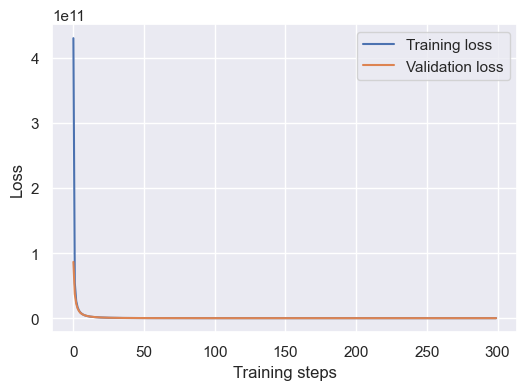

In [85]:
# Plotting the history data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist_forward_ncp_without_loop_gj.history["loss"], label="Training loss")
plt.plot(hist_forward_ncp_without_loop_gj.history["val_loss"], label="Validation loss")

plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

In [86]:
y_test_forward_activation_on_without_loop_gj_predicted2 = ncp_model_without_loop_gj.predict(x_test_forward_activation_on, batch_size=1)

10/10 [==============================] - 1s 10ms/step


<Figure size 800x400 with 0 Axes>

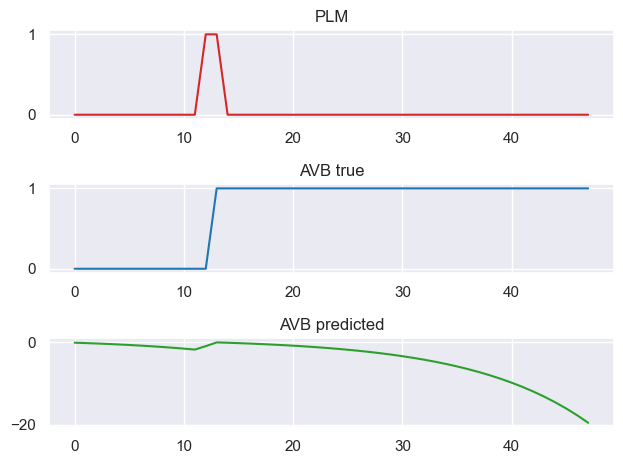

In [87]:
# Plotting the training data
plt.figure(figsize=(8, 4))
fig, axs = plt.subplots(3,1)
axs[0].plot(x_test_forward_activation_on[0, :], 'tab:red')
axs[0].set_title('PLM')
axs[1].plot(y_test_forward_activation_on[0, :], 'tab:blue')
axs[1].set_title('AVB true')
axs[2].plot(np.squeeze(y_test_forward_activation_on_without_loop_gj_predicted2[0, :]), 'tab:green')
axs[2].set_title('AVB predicted')


plt.tight_layout()
plt.show()

## Print learned weights

In [88]:
ncp_model_without_loop_gj.variables

[<tf.Variable 'wired_neurons_2/Gap_Junction_Cell/gleak:0' shape=(1,) dtype=float32, numpy=array([0.8915863], dtype=float32)>,
 <tf.Variable 'wired_neurons_2/Gap_Junction_Cell/vleak:0' shape=(1,) dtype=float32, numpy=array([0.07064702], dtype=float32)>,
 <tf.Variable 'wired_neurons_2/Gap_Junction_Cell/w:0' shape=(1, 1) dtype=float32, numpy=array([[0.9964237]], dtype=float32)>,
 <tf.Variable 'wired_neurons_2/Gap_Junction_Cell/sensory_w:0' shape=(1, 1) dtype=float32, numpy=array([[0.81819886]], dtype=float32)>,
 <tf.Variable 'wired_neurons_2/Gap_Junction_Cell/cm:0' shape=(1,) dtype=float32, numpy=array([1.0715934], dtype=float32)>]